<a href="https://colab.research.google.com/github/ardalanebrahimi/EDU/blob/master/DML_for_text_and_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#import urllib.request
#urllib.request.urlretrieve('http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz', '/content/drive/My Drive/news20.tar.gz')
#import zipfile
#with zipfile.ZipFile('/content/20_newsgroup.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/My Drive')
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/20_newsgroup.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [0]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).
GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)
20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, SimpleRNN, LSTM
from keras.models import Model
from keras.initializers import Constant
from sklearn.datasets import fetch_20newsgroups
from keras.models import Sequential

In [0]:
BASE_DIR = '/content/drive/My Drive/'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove')
BASE_DIR = '/content/'
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')
#newsgroups = fetch_20newsgroups()
#texts = newsgroups.data
#labels = newsgroups.target
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    print(name)
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            #print(fname)
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [0]:
import matplotlib.pyplot as plt
#################################################
def train_val_by_metric(history,metric):
  history_dict = history.history
  #history_dict.keys()
  values = history_dict[metric]
  val_values = history_dict['val_'+metric]

  epochs = range(1, len(values) + 1)
  
  plt.plot(epochs, values, 'bo', label= 'Training '+metric)
  plt.plot(epochs, val_values, 'b', label= 'Validation '+metric)
  metricTitle = 'Loss' if metric == 'loss' else 'Accuracy'
  plt.title('Training and validation '+metricTitle)
  plt.xlabel('Epochs')
  plt.ylabel(metricTitle)
  plt.legend()

  plt.show()
###################################################
def train_val_res(history):
  train_val_by_metric(history,'loss')
  train_val_by_metric(history,'acc')

In [0]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=40,
          validation_data=(x_val, y_val))
train_val_res(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1000, 100)         2000100   
_________________________________________________________________
flatten_8 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                2000020   
Total params: 4,000,120
Trainable params: 4,000,120
Non-trainable params: 0
_________________________________________________________________
Train on 12798 samples, validate on 3200 samples
Epoch 1/10
12798/12798 [==============================] - 2s 193us/step - loss: 2.8301 - acc: 0.1857 - val_loss: 2.2736 - val_acc: 0.3625
Epoch 2/10
12798/12798 [==============================] - 2s 132us/step - loss: 1.5249 - acc: 0.7124 - val_loss: 1.6569 - val_acc: 0.5284
Epoch 3/10
12798/12798 [==============================] - 2s 133us/step

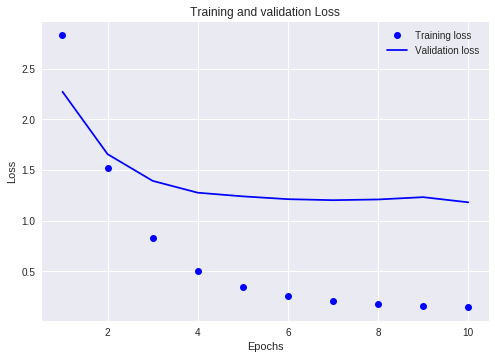

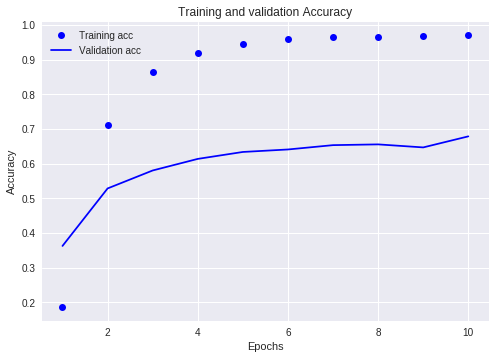

In [0]:
model = Sequential()
#embedding_layer = Embedding(num_words,EMBEDDING_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_SEQUENCE_LENGTH,trainable=False)
model.add(Embedding(num_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(len(labels_index),activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1000, 100)         2000100   
_________________________________________________________________
flatten_9 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 20)                2000020   
Total params: 4,000,120
Trainable params: 4,000,120
Non-trainable params: 0
_________________________________________________________________
Train on 12798 samples, validate on 3200 samples
Epoch 1/40
12798/12798 [==============================] - 3s 204us/step - loss: 2.8765 - acc: 0.1830 - val_loss: 2.2916 - val_acc: 0.3928
Epoch 2/40
12798/12798 [==============================] - 2s 132us/step - loss: 1.5421 - acc: 0.7143 - val_loss: 1.6701 - val_acc: 0.5366
Epoch 3/40
12798/12798 [==============================] - 2s 133us/step

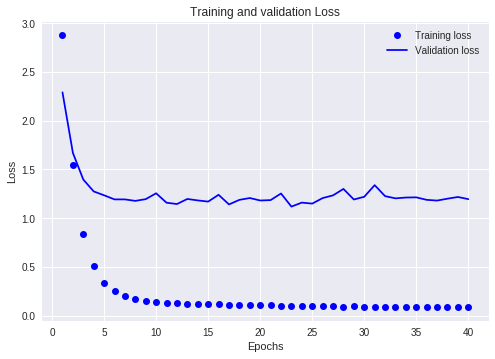

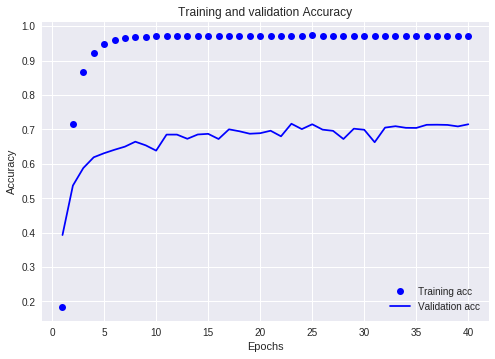

In [0]:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(len(labels_index),activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 40,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1000, 100)         2000100   
_________________________________________________________________
flatten_10 (Flatten)         (None, 100000)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                6400064   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                1300      
Total para

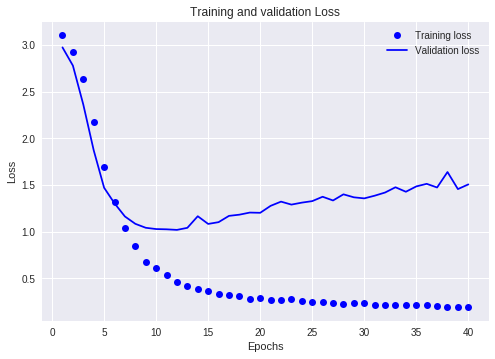

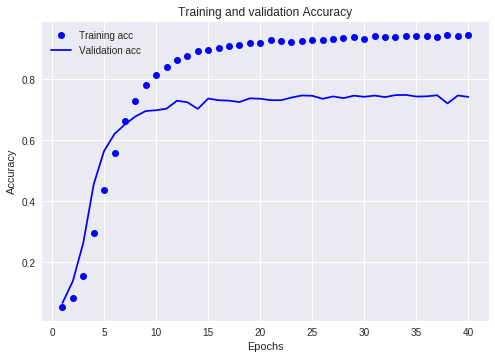

In [0]:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20,activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 40,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

Preparing embedding matrix.
Training model.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 12798 samples, validate on 3200 samples
Epoch 1/40
12798/12798 [==============================] - 4s 275us/step - loss: 3.1090 - acc: 0.0560 - val_loss: 3.0092 - val_acc: 0.0737
Epoch 2/40
12798/12798 [==============================] - 1s 84us/step - loss: 2.8571 - acc: 0.1213 - val_loss: 3.0327 - val_acc: 0.1700
Epoch 3/40
12798/12798 [==============================] - 1s 85us/step - loss: 2.4141 - acc: 0.2479 - val_loss: 2.4504 - val_acc: 0.2419
Epoch 4/40
12798/12798 [==============================] - 1s 83us/step - loss: 1.8751 - acc: 0.4077 - val_loss: 2.1403 - val_acc: 0.3109
Epoch 5/40
12798/12798 [==============================] - 1s 84us/step - loss: 1.4136 - acc: 0.5577 - val_loss: 2.1339 - val_acc: 0.3422
Epoch 6/40
12798/12798 [==============================] - 1s 83us/step - loss: 1.0582 - acc: 0.6786 -

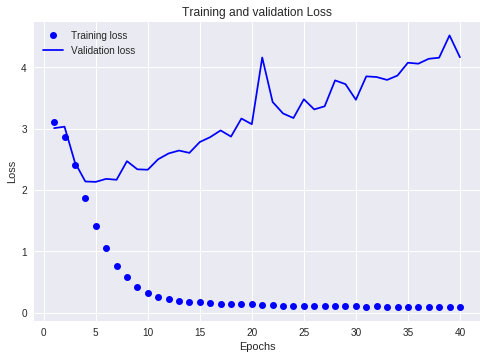

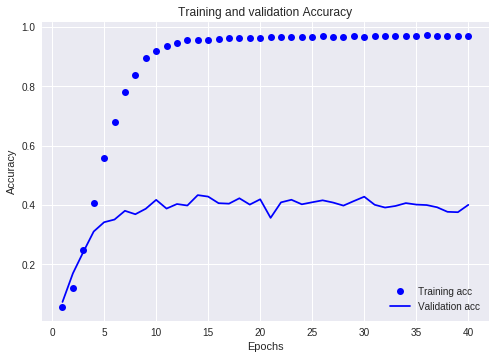

In [0]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Flatten()(embedded_sequences)
x = Dense(32, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train,y_train,
                   epochs = 40,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)
model.save_weights('pre_trained_glove_model')

Preparing embedding matrix.
Training model.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 1000, 100)         2000100   
_________________________________________________________________
flatten_14 (Flatten)         (None, 100000)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                6400064   
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (No

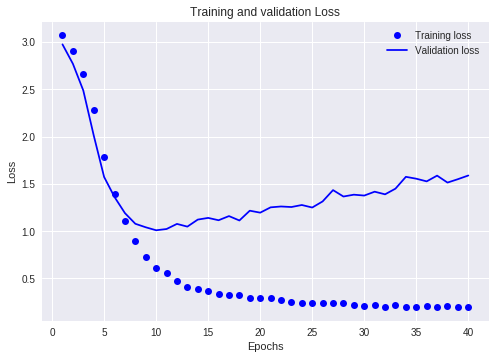

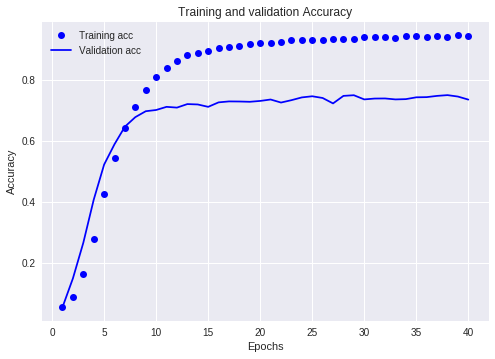

In [0]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print('Training model.')

model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20,activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

#model.layers[0].set_weights([embedding_matrix])
#model.layers[0].trainable =0


model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(x_train,y_train,
                   epochs = 40,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)
model.save_weights('pre_trained_glove_model')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 32)          640032    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 20)                660       
Total params: 642,772
Trainable params: 642,772
Non-trainable params: 0
_________________________________________________________________
Train on 12798 samples, validate on 3200 samples
Epoch 1/10
12798/12798 [==============================] - 46s 4ms/step - loss: 2.8766 - acc: 0.1623 - val_loss: 2.7651 - val_acc: 0.2228
Epoch 2/10
12798/12798 [==============================] - 45s 4ms/step - loss: 2.4249 - acc: 0.3604 - val_loss: 2.4785 - val_acc: 0.2850
Epoch 3/10
12798/12798 [==============================] - 45s 4ms/step - loss

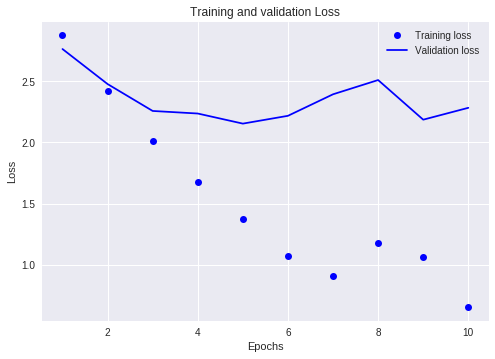

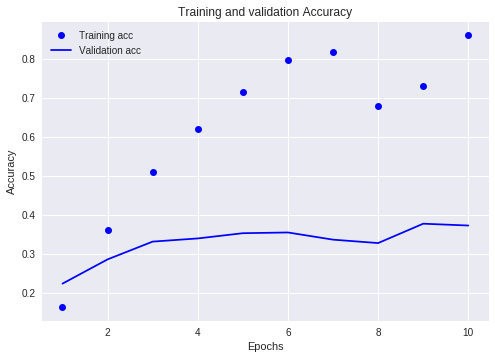

In [0]:
model = Sequential()
model.add(Embedding(num_words,32))
model.add(SimpleRNN(32))
model.add(Dense(20,activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, None, 100)         2000100   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_32 (Dense)             (None, 20)                2020      
Total params: 2,022,220
Trainable params: 2,022,220
Non-trainable params: 0
_________________________________________________________________
Train on 12798 samples, validate on 3200 samples
Epoch 1/10
12798/12798 [==============================] - 47s 4ms/step - loss: 2.9186 - acc: 0.1506 - val_loss: 2.7927 - val_acc: 0.2281
Epoch 2/10
12798/12798 [==============================] - 46s 4ms/step - loss: 2.4370 - acc: 0.3751 - val_loss: 2.4240 - val_acc: 0.3128
Epoch 3/10
12798/12798 [==============================] - 45s 4ms/step - 

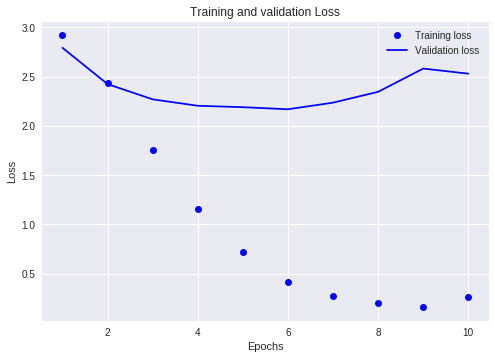

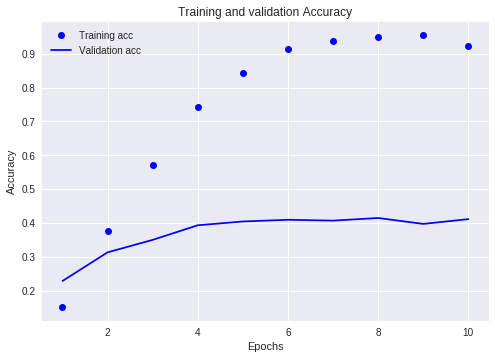

In [0]:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM))
model.add(SimpleRNN(EMBEDDING_DIM))
model.add(Dense(len(labels_index),activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         2000100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
Total params: 2,082,520
Trainable params: 2,082,520
Non-trainable params: 0
_________________________________________________________________
Train on 12798 samples, validate on 3200 samples
Epoch 1/10
12798/12798 [==============================] - 161s 13ms/step - loss: 2.8026 - acc: 0.1288 - val_loss: 2.5742 - val_acc: 0.1675
Epoch 2/10
12798/12798 [==============================] - 160s 12ms/step - loss: 2.3313 - acc: 0.2649 - val_loss: 2.0527 - val_acc: 0.3478
Epoch 3/10
12798/12798 [==============================] - 160s 13ms/s

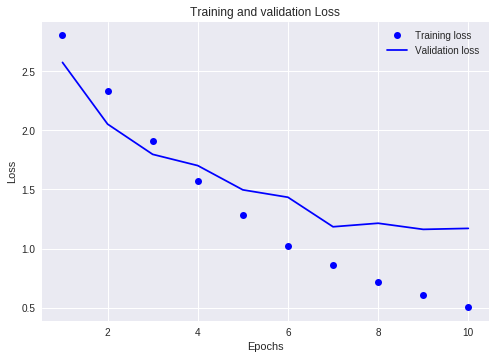

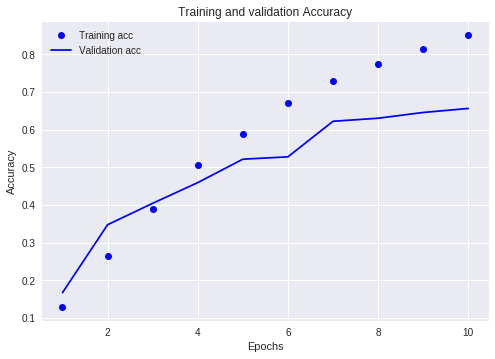

In [0]:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM))
model.add(LSTM(EMBEDDING_DIM))
model.add(Dense(len(labels_index),activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         2000100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
___________________________

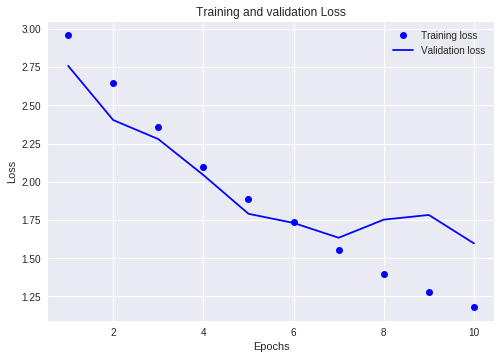

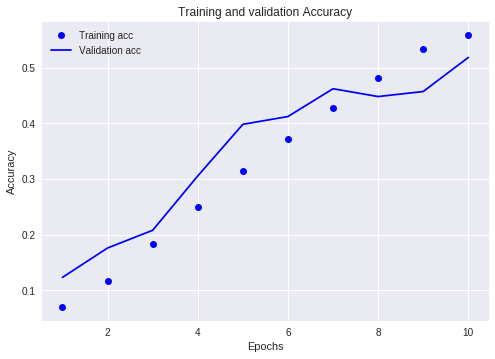

In [0]:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM))
model.add(LSTM(EMBEDDING_DIM))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels_index),activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 10,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         2000100   
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1300      
Total para

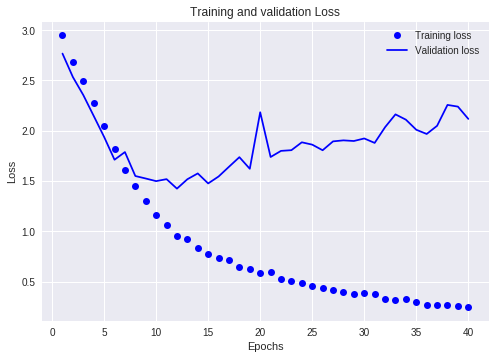

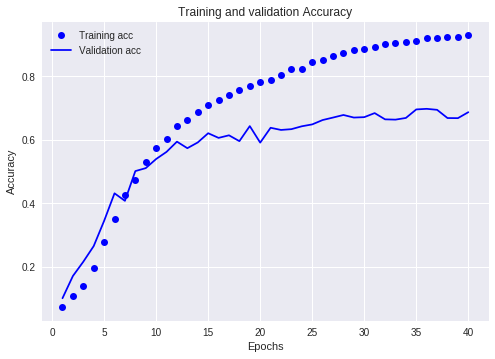

In [0]:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIM))
model.add(LSTM(EMBEDDING_DIM))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(labels_index),activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,
                   epochs = 40,
                   batch_size=128,
                   validation_split=0.2)
train_val_res(history)